# Homework 2 - Data Science with CO2

__Hand-in__:

- __Due: 07.04.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.


### To start with: 

The following csv files will be needed which can be found in the `../data/` folder: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 

Import the following python packages:

In [112]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import array
import os
import random
%matplotlib inline

### PART I: Handling time series with pandas (10 points)

a) **8/10** Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe like this:

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |

The merged dataframe contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [113]:
CO2_sensor = pd.read_csv('../data/CO2_sensor_measurements.csv', sep='\t', index_col='timestamp', parse_dates=True)
CO2_sensor

,LocationName,SensorUnit_ID,CO2
timestamp,,,
2017-10-01 00:05:00,ZGHD,1014,593.321562
2017-10-01 00:15:00,ZGHD,1014,595.846258
2017-10-01 00:25:00,ZGHD,1014,595.845353
2017-10-01 00:45:00,ZGHD,1014,599.039129
2017-10-01 00:55:00,ZGHD,1014,594.996629
...,...,...,...
2017-10-31 23:03:00,ZLDW,1299,476.821183
2017-10-31 23:13:00,ZLDW,1299,477.659209
2017-10-31 23:23:00,ZLDW,1299,479.250364


In [114]:
LocationNames = CO2_sensor['LocationName'].unique()
SensorIDs     = CO2_sensor['SensorUnit_ID'].unique()
myDF = []
for i,sensor_id in enumerate(CO2_sensor['SensorUnit_ID'].unique()):
    temp = CO2_sensor.loc[CO2_sensor['SensorUnit_ID'] == sensor_id]['CO2'].to_frame()
    temp = temp.resample('30T').mean().interpolate()
    temp['LocationName'] = LocationNames[i]
    temp['SensorUnit_ID'] = SensorIDs[i]
    # display(temp)
    myDF.append(temp)
myDF = pd.concat(myDF)
myDF

,CO2,LocationName,SensorUnit_ID
timestamp,,,
2017-10-01 00:00:00,595.004391,ZGHD,1014
2017-10-01 00:30:00,597.017879,ZGHD,1014
2017-10-01 01:00:00,596.487010,ZGHD,1014
2017-10-01 01:30:00,598.787639,ZGHD,1014
2017-10-01 02:00:00,595.366394,ZGHD,1014
...,...,...,...
2017-10-31 21:30:00,477.307329,ZLDW,1299
2017-10-31 22:00:00,474.396830,ZLDW,1299
2017-10-31 22:30:00,474.406102,ZLDW,1299


In [115]:
sensors_metadata = pd.read_csv('../data/sensors_metadata_updated.csv', sep=',', index_col=0)
sensors_metadata

,LocationName,zone,altitude,LAT,LON,X,Y
0,AJGR,2,627.8,47.333210,8.480300,243005.0000,678731.4000
1,BSCR,2,462.3,47.355810,8.430070,245468.0000,674903.4000
2,BUDF,10,490.2,47.362700,8.433110,246237.5000,675123.8000
3,KBRL,7,510.5,47.325820,8.537550,242242.3000,683070.1000
4,KTGM,2,530.3,47.323340,8.596422,242031.0000,687523.9000
5,RCTZ,7,440.9,47.434277,8.506933,254268.0000,680591.0000
6,SMHK,2,404.4,47.394410,8.445830,249775.3000,676039.3000
7,SZGL,2,391.9,47.405815,8.445361,251042.0000,675987.0000
8,ULGW,6,627.1,47.357480,8.469090,245692.4000,677849.0000
9,UTLI,10,863.6,47.351406,8.490318,245038.1952,679461.7230


In [116]:
myDF2 = pd.merge(left=myDF, right=sensors_metadata[['LocationName','zone','altitude','LAT','LON']], on='LocationName').set_index(myDF.index)
myDF2

,CO2,LocationName,SensorUnit_ID,zone,altitude,LAT,LON
timestamp,,,,,,,
2017-10-01 00:00:00,595.004391,ZGHD,1014,2,413.5,47.370446,8.523256
2017-10-01 00:30:00,597.017879,ZGHD,1014,2,413.5,47.370446,8.523256
2017-10-01 01:00:00,596.487010,ZGHD,1014,2,413.5,47.370446,8.523256
2017-10-01 01:30:00,598.787639,ZGHD,1014,2,413.5,47.370446,8.523256
2017-10-01 02:00:00,595.366394,ZGHD,1014,2,413.5,47.370446,8.523256
...,...,...,...,...,...,...,...
2017-10-31 21:30:00,477.307329,ZLDW,1299,5,405.9,47.348870,8.536290
2017-10-31 22:00:00,474.396830,ZLDW,1299,5,405.9,47.348870,8.536290
2017-10-31 22:30:00,474.406102,ZLDW,1299,5,405.9,47.348870,8.536290


In [117]:
temp_humid = pd.read_csv('../data/temperature_humidity.csv', sep='\t', index_col='Timestamp', parse_dates=True)
temp_humid

,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,1018.humidity,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,91.427368,...,10.13,96.828979,10.50,95.858139,10.70,94.524902,11.35,90.288681,11.44,90.118927
2017-10-01 00:10:00,11.39,92.579407,10.48,92.079681,11.04,93.063873,11.05,90.042633,11.38,91.240448,...,10.12,97.322983,10.45,95.903915,10.53,94.395203,11.35,90.422195,11.46,90.073151
2017-10-01 00:20:00,11.41,92.480225,10.51,92.583221,11.06,93.201202,11.02,89.888138,11.35,90.511841,...,10.14,97.780746,10.43,95.343155,10.45,94.620270,11.33,91.023010,11.41,89.466614
2017-10-01 00:30:00,11.35,91.902298,10.55,92.714828,11.02,92.932266,10.96,89.790863,11.31,90.481323,...,10.13,97.904724,10.43,95.322174,10.42,94.973129,11.32,91.019196,11.39,89.249176
2017-10-01 00:40:00,11.30,91.639084,10.59,92.764420,10.99,92.598480,10.95,89.821381,11.27,89.668793,...,10.13,97.931427,10.48,96.451324,10.46,95.282120,11.28,90.443176,11.31,88.871521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 23:10:00,4.66,79.254669,0.99,89.418930,3.24,85.516495,3.96,79.712433,4.46,79.199356,...,1.86,94.246429,-0.43,95.573944,-0.17,93.636078,3.08,81.087631,3.38,81.772369
2017-10-31 23:20:00,4.58,79.361481,0.89,89.520020,3.18,85.444016,3.87,79.887909,4.35,79.380554,...,1.93,94.587845,-0.48,96.170944,-0.19,93.880219,3.02,81.764740,3.39,81.783813
2017-10-31 23:30:00,4.51,79.578918,0.79,89.829010,3.07,85.798782,3.78,80.112976,4.26,79.622787,...,1.83,94.797653,-0.41,96.235794,-0.12,94.315094,NaN,NaN,3.35,81.820053


In [118]:
df_temphumid = temp_humid.resample('30T').mean().interpolate()
df_temphumid

,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,1018.humidity,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,10.513333,92.204295,11.040000,92.959605,11.040000,89.914205,11.370000,91.059886,...,10.130000,97.310903,10.460000,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.886230
2017-10-01 00:30:00,11.325000,91.770691,10.576667,92.773956,10.996667,92.644257,10.960000,89.787048,11.273333,89.996857,...,10.130000,97.918076,10.456667,96.094014,10.463333,95.242065,11.290000,90.549988,11.326667,88.851176
2017-10-01 01:00:00,11.240000,91.096761,10.560000,92.866781,10.953333,92.062515,10.980000,89.294952,11.235000,90.005440,...,10.003333,96.909724,10.393333,97.449504,10.576667,95.600011,11.230000,89.885595,11.263333,88.593048
2017-10-01 01:30:00,11.260000,91.275734,10.510000,92.942439,10.896667,92.285675,10.993333,89.351537,11.223333,89.887502,...,9.916667,96.642695,10.310000,97.076935,10.516667,95.526896,11.245000,89.779419,11.300000,89.286051
2017-10-01 02:00:00,11.290000,91.061157,10.436667,92.884583,10.870000,92.477681,11.033333,89.207850,11.253333,89.595042,...,9.866667,96.340698,10.326667,97.756587,10.370000,95.427078,11.236667,90.560796,11.290000,89.628738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,5.275000,76.427979,1.580000,86.436473,4.106667,82.618596,4.626667,76.995097,5.073333,76.424800,...,2.390000,88.979604,0.140000,94.441615,0.506667,90.646627,3.833333,77.984375,3.923333,78.965388
2017-10-31 22:00:00,5.060000,77.560944,1.463333,88.061534,3.830000,83.364370,4.280000,78.320068,4.850000,77.663940,...,2.253333,89.235189,-0.050000,95.224264,0.146667,91.686132,3.505000,79.033417,3.766667,79.702896
2017-10-31 22:30:00,4.826667,78.838867,1.226667,88.594320,3.550000,84.100606,4.173333,79.130692,4.696667,78.695180,...,1.830000,91.760518,-0.236667,95.661046,0.053333,92.941167,3.280000,80.523056,3.493333,80.769740


In [119]:
myDF3 = pd.merge(left=myDF2, right=df_temphumid, left_index=True, right_index=True)
myDF3

,CO2,LocationName,SensorUnit_ID,zone,altitude,LAT,LON,1014.temperature,1014.humidity,1015.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
2017-10-01 00:00:00,595.004391,ZGHD,1014,2,413.5,47.370446,8.523256,11.396667,92.440806,10.513333,...,10.13,97.310903,10.46,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.88623
2017-10-01 00:00:00,472.855962,ZORL,1015,5,439.9,47.414780,8.537913,11.396667,92.440806,10.513333,...,10.13,97.310903,10.46,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.88623
2017-10-01 00:00:00,440.373573,ZTBN,1016,2,402.9,47.389721,8.517753,11.396667,92.440806,10.513333,...,10.13,97.310903,10.46,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.88623
2017-10-01 00:00:00,425.095878,ZHRG,1017,3,410.5,47.377773,8.519460,11.396667,92.440806,10.513333,...,10.13,97.310903,10.46,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.88623
2017-10-01 00:00:00,425.687625,ZSCH,1018,2,413.1,47.370983,8.523569,11.396667,92.440806,10.513333,...,10.13,97.310903,10.46,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.88623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 23:30:00,420.311299,ZFHB,1291,8,518.5,47.395000,8.551740,4.456667,79.830688,0.853333,...,1.89,94.947698,-0.44,96.288564,-0.033333,94.645065,2.855000,82.758469,3.286667,81.91097
2017-10-31 23:30:00,552.212598,RCTZ,1292,7,440.9,47.434277,8.506933,4.456667,79.830688,0.853333,...,1.89,94.947698,-0.44,96.288564,-0.033333,94.645065,2.855000,82.758469,3.286667,81.91097
2017-10-31 23:30:00,502.498423,WRTW,1297,2,451.4,47.418366,8.603844,4.456667,79.830688,0.853333,...,1.89,94.947698,-0.44,96.288564,-0.033333,94.645065,2.855000,82.758469,3.286667,81.91097
2017-10-31 23:30:00,488.848420,ZSEF,1298,2,415.1,47.357170,8.555190,4.456667,79.830688,0.853333,...,1.89,94.947698,-0.44,96.288564,-0.033333,94.645065,2.855000,82.758469,3.286667,81.91097


In [120]:
temp=[]
humid=[]
for index, row in myDF3.iterrows():
    sensorid = row['SensorUnit_ID']
    temp.append(row[str(sensorid)+'.temperature'])
    humid.append(row[str(sensorid)+'.humidity'])
myDF3['temperature'] = temp
myDF3['humidity'] = humid
columns = [c for c in myDF3.columns if '.' not in c]
myDF4 = myDF3[columns].rename({'LAT':'lat', 'LON':'lon'}, axis='columns')
myDF4

,CO2,LocationName,SensorUnit_ID,zone,altitude,lat,lon,temperature,humidity
2017-10-01 00:00:00,595.004391,ZGHD,1014,2,413.5,47.370446,8.523256,11.396667,92.440806
2017-10-01 00:00:00,472.855962,ZORL,1015,5,439.9,47.414780,8.537913,10.513333,92.204295
2017-10-01 00:00:00,440.373573,ZTBN,1016,2,402.9,47.389721,8.517753,11.040000,92.959605
2017-10-01 00:00:00,425.095878,ZHRG,1017,3,410.5,47.377773,8.519460,11.040000,89.914205
2017-10-01 00:00:00,425.687625,ZSCH,1018,2,413.1,47.370983,8.523569,11.370000,91.059886
...,...,...,...,...,...,...,...,...,...
2017-10-31 23:30:00,420.311299,ZFHB,1291,8,518.5,47.395000,8.551740,1.890000,94.947698
2017-10-31 23:30:00,552.212598,RCTZ,1292,7,440.9,47.434277,8.506933,-0.440000,96.288564
2017-10-31 23:30:00,502.498423,WRTW,1297,2,451.4,47.418366,8.603844,-0.033333,94.645065
2017-10-31 23:30:00,488.848420,ZSEF,1298,2,415.1,47.357170,8.555190,2.855000,82.758469


In [121]:
columns = ['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity', 'zone', 'altitude', 'lon', 'lat']
df_final = myDF4[columns]
df_final.index.name = 'timestamp'
df_final

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat
timestamp,,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,2,413.5,8.523256,47.370446
2017-10-01 00:00:00,ZORL,1015,472.855962,10.513333,92.204295,5,439.9,8.537913,47.414780
2017-10-01 00:00:00,ZTBN,1016,440.373573,11.040000,92.959605,2,402.9,8.517753,47.389721
2017-10-01 00:00:00,ZHRG,1017,425.095878,11.040000,89.914205,3,410.5,8.519460,47.377773
2017-10-01 00:00:00,ZSCH,1018,425.687625,11.370000,91.059886,2,413.1,8.523569,47.370983
...,...,...,...,...,...,...,...,...,...
2017-10-31 23:30:00,ZFHB,1291,420.311299,1.890000,94.947698,8,518.5,8.551740,47.395000
2017-10-31 23:30:00,RCTZ,1292,552.212598,-0.440000,96.288564,7,440.9,8.506933,47.434277
2017-10-31 23:30:00,WRTW,1297,502.498423,-0.033333,94.645065,2,451.4,8.603844,47.418366


In [123]:
df_final.sort_values(by=['LocationName', 'timestamp'], inplace=True)
df_final

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat
timestamp,,,,,,,,,
2017-10-01 00:00:00,AJGR,1122,340.231893,9.800000,95.893425,2,627.8,8.48030,47.33321
2017-10-01 00:30:00,AJGR,1122,341.213293,9.766667,95.945241,2,627.8,8.48030,47.33321
2017-10-01 01:00:00,AJGR,1122,338.625034,9.605000,95.744652,2,627.8,8.48030,47.33321
2017-10-01 01:30:00,AJGR,1122,342.874127,9.550000,95.676941,2,627.8,8.48030,47.33321
2017-10-01 02:00:00,AJGR,1122,345.171710,9.526667,95.360321,2,627.8,8.48030,47.33321
...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,ZWCH,1178,506.691097,2.496667,85.857274,2,450.0,8.52706,47.34303
2017-10-31 22:00:00,ZWCH,1178,507.707888,2.200000,86.636108,2,450.0,8.52706,47.34303
2017-10-31 22:30:00,ZWCH,1178,509.046495,1.940000,88.024658,2,450.0,8.52706,47.34303


b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [124]:
df_final.to_csv('../data/merged_data.csv')

### PART II: Data visualization (15 points)

a) **5/15** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Write out the formula of metric you intend to use for Elbow curve. Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [125]:
df_final = pd.read_csv('../data/merged_data.csv', index_col='timestamp', parse_dates=True)

In [126]:
altitudes = df_final['altitude'].values.reshape(-1,1)

In [127]:
from yellowbrick.cluster import KElbowVisualizer

In [128]:
from sklearn.cluster import KMeans
model = KMeans()

By default, the **distortion metric** is used which computes the sum of squared distances from each point to its assigned center.

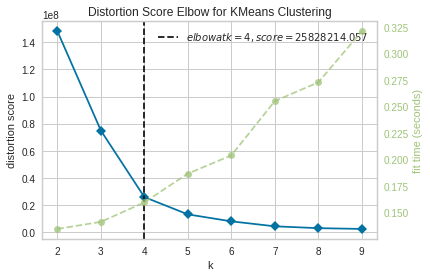

In [129]:
# distortion metric
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')
visualizer.fit(altitudes)
visualizer.show()

By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center. However, two other metrics can also be used with the KElbowVisualizer – `silhouette` and `calinski_harabasz`. The silhouette score calculates the mean Silhouette Coefficient of all samples, while the calinski_harabasz score computes the ratio of dispersion between and within clusters.

/opt/conda/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/conda/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


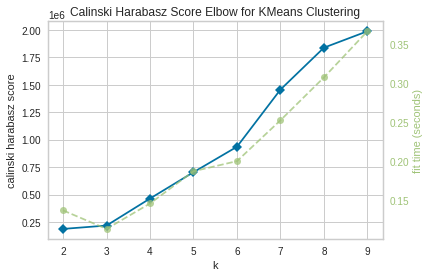

In [130]:
# calinski_harabasz score
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz')
visualizer.fit(altitudes)
visualizer.show()

It seems that `calinski_harabasz` metric does not yield good results in our case.

In [131]:
# KMeans clustering
# Cluster size is 4 from previous question
model = KMeans(n_clusters=4).fit(altitudes)
model.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [135]:
df_final['cluster_ID'] = model.labels_
df_final

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat,cluster_ID
timestamp,,,,,,,,,,
2017-10-01 00:00:00,AJGR,1122,340.231893,9.800000,95.893425,2,627.8,8.48030,47.33321,1
2017-10-01 00:30:00,AJGR,1122,341.213293,9.766667,95.945241,2,627.8,8.48030,47.33321,1
2017-10-01 01:00:00,AJGR,1122,338.625034,9.605000,95.744652,2,627.8,8.48030,47.33321,1
2017-10-01 01:30:00,AJGR,1122,342.874127,9.550000,95.676941,2,627.8,8.48030,47.33321,1
2017-10-01 02:00:00,AJGR,1122,345.171710,9.526667,95.360321,2,627.8,8.48030,47.33321,1
...,...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,ZWCH,1178,506.691097,2.496667,85.857274,2,450.0,8.52706,47.34303,0
2017-10-31 22:00:00,ZWCH,1178,507.707888,2.200000,86.636108,2,450.0,8.52706,47.34303,0
2017-10-31 22:30:00,ZWCH,1178,509.046495,1.940000,88.024658,2,450.0,8.52706,47.34303,0


b) **3/15** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName), and give the same color to stations that belong to the same altitude  cluster.    

c) **7/15** Plot the stations on an interactive Zurich map, and dispay their location name. And, on the same map, plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.

__Note__: You can use the python library [Folium](https://python-visualization.github.io/folium/) for that, but any other visualization tools can be used.

### PART III: Model fitting for data curation (35 points)

a) __3/35__ How to handle missing data matters in real-world data science project. Although here we have all the data, it is still a very good opportunity for you to learn. Let's assume there is one site `KBRL` which somehow lost all the CO2 data of `2017-10-04`. Compare different ways of interpolating for the missing values (in time: linear interpolation and cubic interpolation, in space: using other sensors in the same altitude cluster) and plot the interpolation results. Use the data you have as the ground truth to discuss your findings.

In [137]:
df_final.loc[df_final['LocationName'] == 'KBRL']

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat,cluster_ID
timestamp,,,,,,,,,,
2017-10-01 00:00:00,KBRL,1176,402.759373,10.536667,92.604838,7,510.5,8.53755,47.32582,3
2017-10-01 00:30:00,KBRL,1176,399.279863,10.370000,92.905563,7,510.5,8.53755,47.32582,3
2017-10-01 01:00:00,KBRL,1176,403.017115,10.326667,92.473231,7,510.5,8.53755,47.32582,3
2017-10-01 01:30:00,KBRL,1176,404.367073,10.250000,92.098755,7,510.5,8.53755,47.32582,3
2017-10-01 02:00:00,KBRL,1176,407.390903,10.170000,92.398209,7,510.5,8.53755,47.32582,3
...,...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,KBRL,1176,441.223796,2.656667,86.116674,7,510.5,8.53755,47.32582,3
2017-10-31 22:00:00,KBRL,1176,437.335350,2.693333,86.798869,7,510.5,8.53755,47.32582,3
2017-10-31 22:30:00,KBRL,1176,431.848150,2.376667,87.153636,7,510.5,8.53755,47.32582,3


In [138]:
# df_final = pd.read_csv('../data/merged_data.csv', index_col='timestamp', parse_dates=True)
df_kbrl = df_final.loc[df_final['cluster_ID'] == 3] # 3 is the cluster ID of KBRL
ground_truth = df_kbrl.loc[(datetime.date(2017,10,4) == df_kbrl.index.date) & (df_kbrl['LocationName'] == 'KBRL')]
ground_truth

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat,cluster_ID
timestamp,,,,,,,,,,
2017-10-04 00:00:00,KBRL,1176,401.702249,10.596667,76.635880,7,510.5,8.53755,47.32582,3
2017-10-04 00:30:00,KBRL,1176,406.393932,10.680000,76.431157,7,510.5,8.53755,47.32582,3
2017-10-04 01:00:00,KBRL,1176,406.798785,10.526667,77.201726,7,510.5,8.53755,47.32582,3
2017-10-04 01:30:00,KBRL,1176,416.158277,9.960000,77.628337,7,510.5,8.53755,47.32582,3
2017-10-04 02:00:00,KBRL,1176,422.556122,9.270000,80.417516,7,510.5,8.53755,47.32582,3
2017-10-04 02:30:00,KBRL,1176,420.275839,8.803333,82.872274,7,510.5,8.53755,47.32582,3
2017-10-04 03:00:00,KBRL,1176,424.337517,8.173333,86.420578,7,510.5,8.53755,47.32582,3
2017-10-04 03:30:00,KBRL,1176,431.494300,7.696667,88.026566,7,510.5,8.53755,47.32582,3
2017-10-04 04:00:00,KBRL,1176,446.151997,7.493333,89.196406,7,510.5,8.53755,47.32582,3


In [140]:
df_kbrl.loc[(datetime.date(2017,10,4) == df_kbrl.index.date) & (df_kbrl['LocationName'] == 'KBRL'), 'CO2'] = np.nan
df_kbrl.loc[(datetime.date(2017,10,4) == df_kbrl.index.date) & (df_kbrl['LocationName'] == 'KBRL')]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat,cluster_ID
timestamp,,,,,,,,,,
2017-10-04 00:00:00,KBRL,1176,NaN,10.596667,76.635880,7,510.5,8.53755,47.32582,3
2017-10-04 00:30:00,KBRL,1176,NaN,10.680000,76.431157,7,510.5,8.53755,47.32582,3
2017-10-04 01:00:00,KBRL,1176,NaN,10.526667,77.201726,7,510.5,8.53755,47.32582,3
2017-10-04 01:30:00,KBRL,1176,NaN,9.960000,77.628337,7,510.5,8.53755,47.32582,3
2017-10-04 02:00:00,KBRL,1176,NaN,9.270000,80.417516,7,510.5,8.53755,47.32582,3
2017-10-04 02:30:00,KBRL,1176,NaN,8.803333,82.872274,7,510.5,8.53755,47.32582,3
2017-10-04 03:00:00,KBRL,1176,NaN,8.173333,86.420578,7,510.5,8.53755,47.32582,3
2017-10-04 03:30:00,KBRL,1176,NaN,7.696667,88.026566,7,510.5,8.53755,47.32582,3
2017-10-04 04:00:00,KBRL,1176,NaN,7.493333,89.196406,7,510.5,8.53755,47.32582,3


In [142]:
df_kbrl.sort_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
df_kbrl.sort_values(by=['timestamp','LocationName'],inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


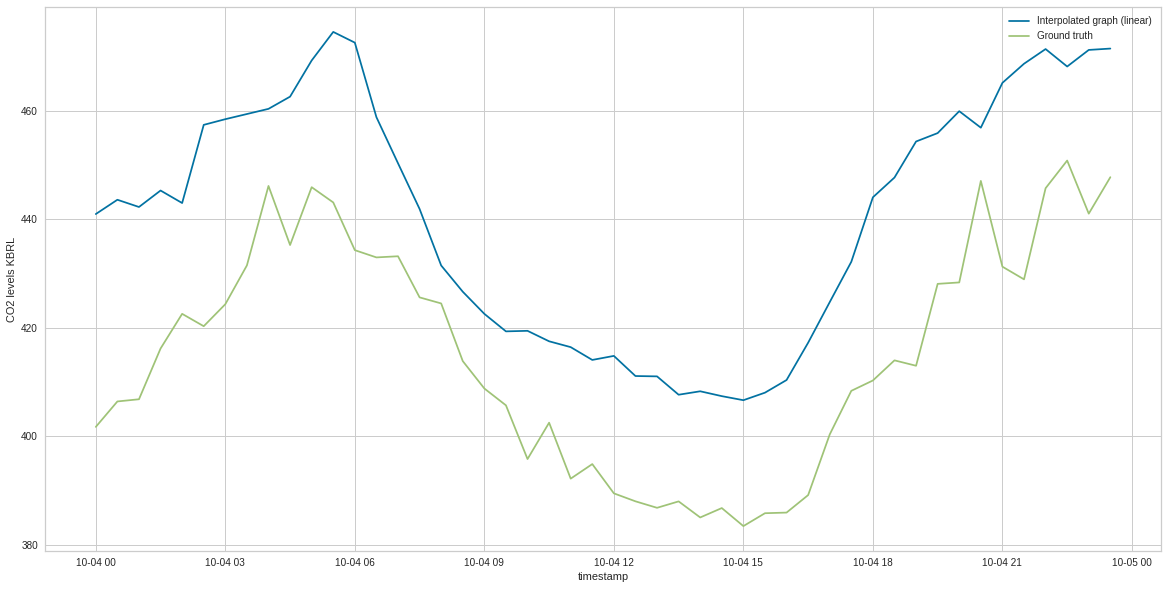

In [173]:
df_kbrl_time_linear = df_kbrl.interpolate(method='linear')
interpolated_linear = df_kbrl_time_linear.loc[(datetime.date(2017,10,4) == df_kbrl_time_linear.index.date) & (df_kbrl['LocationName'] == 'KBRL')]
plt.figure(figsize=(20,10))
plt.plot(interpolated_linear['CO2'])
plt.plot(ground_truth['CO2'])
plt.xlabel('timestamp')
plt.ylabel('CO2 levels KBRL')
plt.grid(True)
plt.legend(['Interpolated graph (linear)','Ground truth'])
plt.show()

In [ ]:
import scipy
scipy.interpolate.interp1d(df_)

In [177]:
df_kbrl_time_qubic = df_kbrl.interpolate(method='cubic')
interpolated_qubic = df_kbrl_time_qubic.loc[(datetime.date(2017,10,4) == df_kbrl_time_qubic.index.date) & (df_kbrl_time_qubic['LocationName'] == 'KBRL')]
plt.figure(figsize=(20,10))
plt.plot(interpolated_qubic['CO2'])
plt.plot(ground_truth['CO2'])
plt.xlabel('timestamp')
plt.ylabel('CO2 levels KBRL')
plt.grid(True)
plt.legend(['Interpolated graph (cubic)','Ground truth'])
plt.show()

ValueError: Expect x to be a 1-D sorted array_like.

b) **2/35** The technician in charge of these sensors reported that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 21. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other sensors from the network. 

In [23]:
df_final.columns

Index(['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity',
       'zone', 'altitude', 'lon', 'lat'],
      dtype='object')

In [77]:
df_co2 = df_final[["LocationName","CO2"]]
df_co2_zsbn = df_co2[df_co2['LocationName'] == "ZSBN"]
df_days = df_co2_zsbn.assign(day = lambda x: x.index.date).set_index("day")
df_grouped = df_days.groupby(['day']).mean()
df_grouped.head()

,LocationName,CO2
day,,
2017-10-01,ZSBN,418.493079
2017-10-01,ZSBN,418.169200
2017-10-01,ZSBN,421.749522
2017-10-01,ZSBN,424.363039
2017-10-01,ZSBN,423.172512


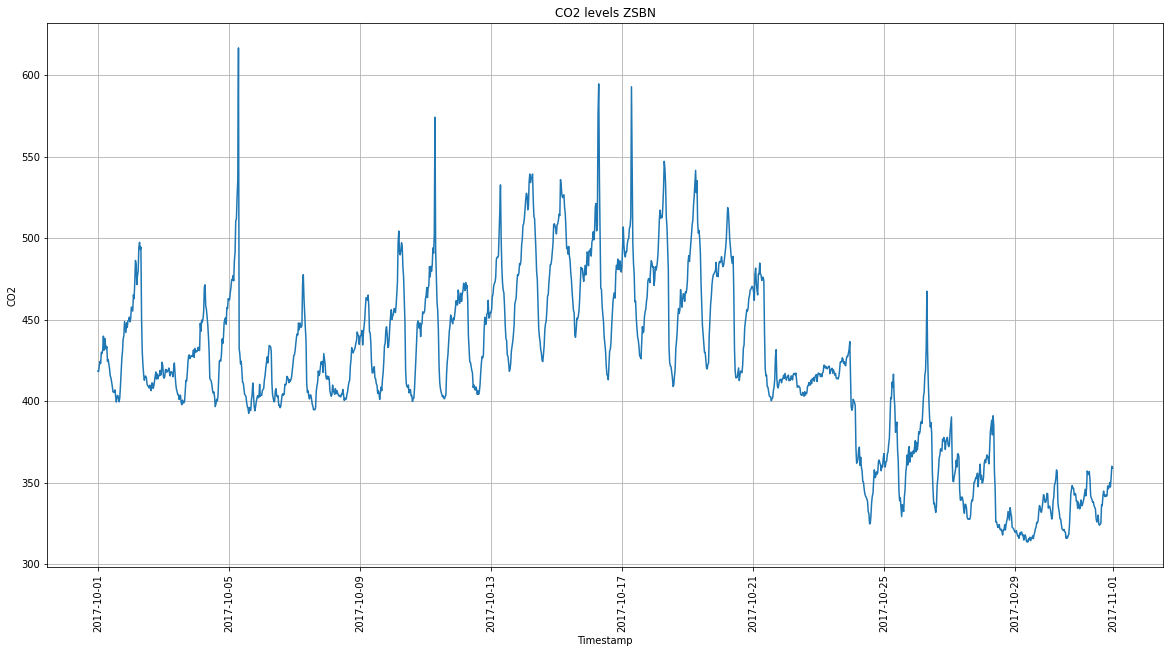

In [107]:
plt.figure(figsize=(20,10))
plt.plot(df_co2_zsbn["CO2"])
plt.xlabel("Timestamp")
plt.ylabel("CO2")
plt.title('CO2 levels ZSBN')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

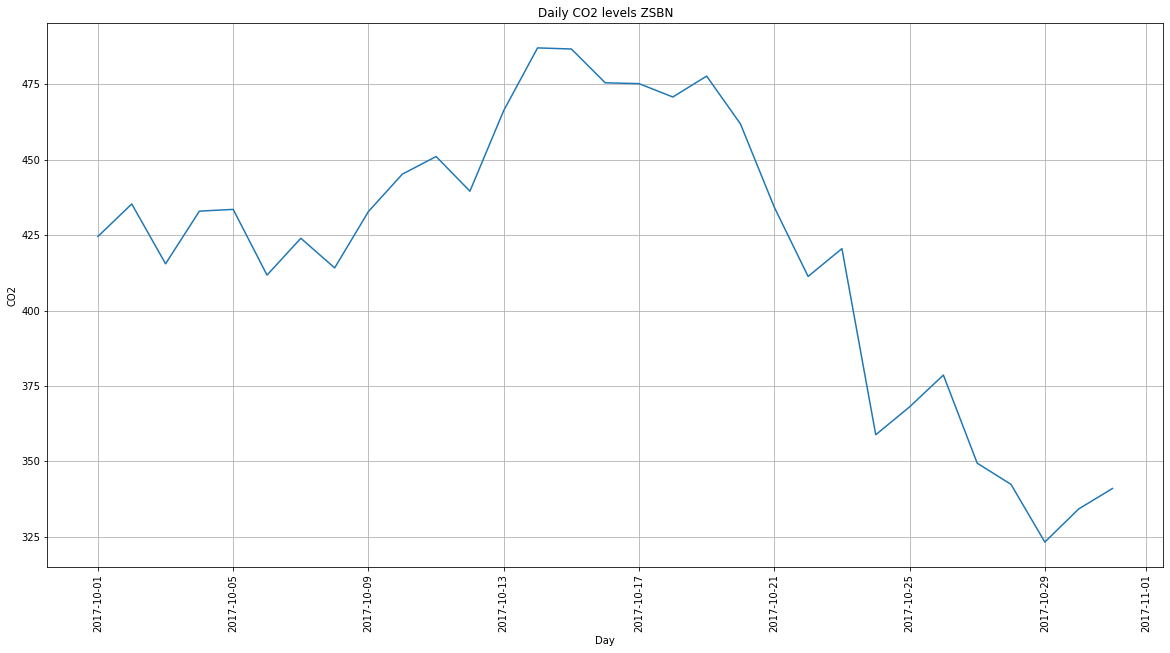

In [108]:
plt.figure(figsize=(20,10))
plt.plot(df_grouped)
plt.xlabel("Day")
plt.ylabel("CO2")
plt.title('Daily CO2 levels ZSBN')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

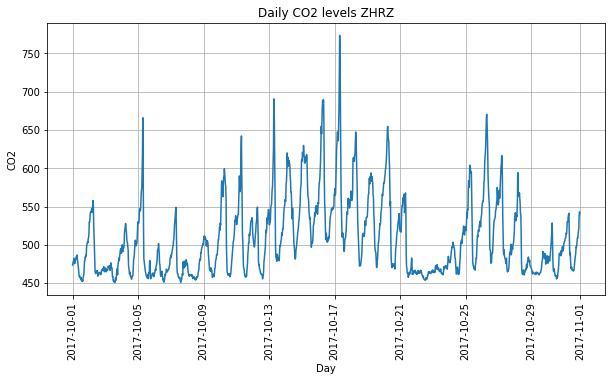

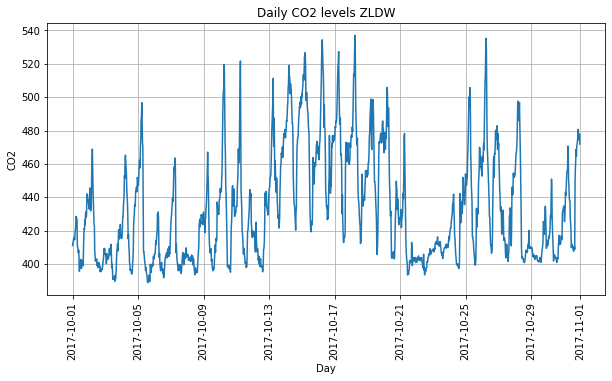

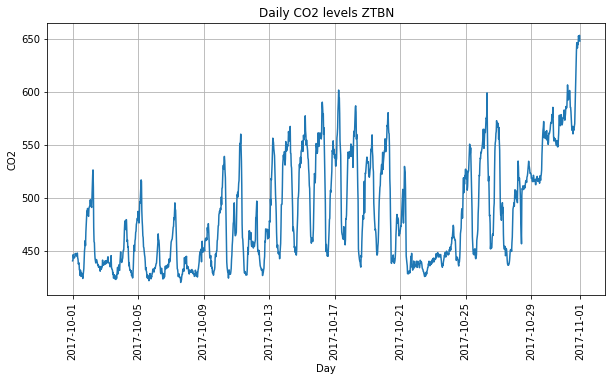

In [226]:

locations = df_final["LocationName"].unique()[:-1]
#select random sample
locations = random.sample(list(locations),3)
locations
for location in locations:
    df_co2_loc = df_co2[df_co2['LocationName'] == location]
    df_days = df_co2_loc.assign(day = lambda x: x.index.date).set_index("day")
    plt.figure(figsize=(10,5))
    plt.plot(df_co2_loc["CO2"])
    plt.xlabel("Day")
    plt.ylabel("CO2")
    plt.title('Daily CO2 levels '+location)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

c) **6/35** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours (past 6 observations), mathematically, $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, where $C_i$ is the CO2 value at time $i$.

Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. What do you observe? 

__Note__: 
1. Cross validation on time series is different from that on other kinds of datasets. scikit-learn provides a nice method for you, `sklearn.model_selection.TimeSeriesSplit`. For more on time series cross validation, there are a lot of interesting articles available online.
2. Think about how to make prediction on data before the drift and after the drift. What's the difference?

In [183]:
df_co2_zsbn.head()

,LocationName,CO2
timestamp,,
2017-10-01 00:00:00,ZSBN,418.493079
2017-10-01 00:30:00,ZSBN,418.169200
2017-10-01 01:00:00,ZSBN,421.749522
2017-10-01 01:30:00,ZSBN,424.363039
2017-10-01 02:00:00,ZSBN,423.172512


In [461]:
df_co2_zsbn
datasize = len(df_co2_zsbn)- 6
X = np.zeros((datasize, 6))
y = np.zeros((datasize, 1))
for i in range(datasize):
        X[i, :] = np.asarray([df_co2_zsbn["CO2"][i:i+6]])
        y[i] = df_co2_zsbn["CO2"][i+6]

In [361]:
X

array([[418.49307929, 418.16920018, 421.74952166, 424.36303875,
        423.17251204, 429.95549484],
       [418.16920018, 421.74952166, 424.36303875, 423.17251204,
        429.95549484, 429.26024002],
       [421.74952166, 424.36303875, 423.17251204, 429.95549484,
        429.26024002, 431.30519129],
       ...,
       [341.97126935, 347.94973357, 346.2580176 , 347.22239223,
        350.08649382, 347.27036994],
       [347.94973357, 346.2580176 , 347.22239223, 350.08649382,
        347.27036994, 352.79901853],
       [346.2580176 , 347.22239223, 350.08649382, 347.27036994,
        352.79901853, 360.01170948]])

In [362]:
y

array([[429.26024002],
       [431.30519129],
       [439.9189803 ],
       ...,
       [352.79901853],
       [360.01170948],
       [358.83542153]])

In [373]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

In [377]:
tscv = TimeSeriesSplit()#default is 5 folds
currenterror = 1000000
for train_index, test_index in tscv.split(X):
    X_train,X_test,y_train,y_test = X[train_index],X[test_index],y[train_index],y[test_index]
    lr = LinearRegression(fit_intercept=False)
    lr = lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    scores = cross_val_score(lr, X_train, y_train, cv=tscv)
    print(scores)
    error = mean_squared_error(y_test, y_test_pred)
    print("MSE: "+ str(error))
    print("Average acc: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
    if currenterror > error:
        print(currenterror)
        currenterror = error
        lr_final = lr

[0.90510302 0.79718345 0.87113556 0.32010029 0.46842838]
MSE: 91.68527538432106
Average acc: 0.672 (+/- 0.234)
1000000
[0.91182612 0.57473553 0.86427    0.93992685 0.78999895]
MSE: 104.11350149659414
Average acc: 0.816 (+/- 0.131)
[0.57601662 0.8726117  0.82567921 0.93738348 0.87773735]
MSE: 110.71600171146811
Average acc: 0.818 (+/- 0.126)
[0.64708281 0.87033438 0.95786779 0.81870106 0.93894461]
MSE: 43.26222228955235
Average acc: 0.847 (+/- 0.111)
91.68527538432106
[0.90167306 0.87436412 0.85835587 0.95403912 0.9487006 ]
MSE: 25.20840328548169
Average acc: 0.907 (+/- 0.038)
43.26222228955235


In [378]:
y_pred = lr_final.predict(X)

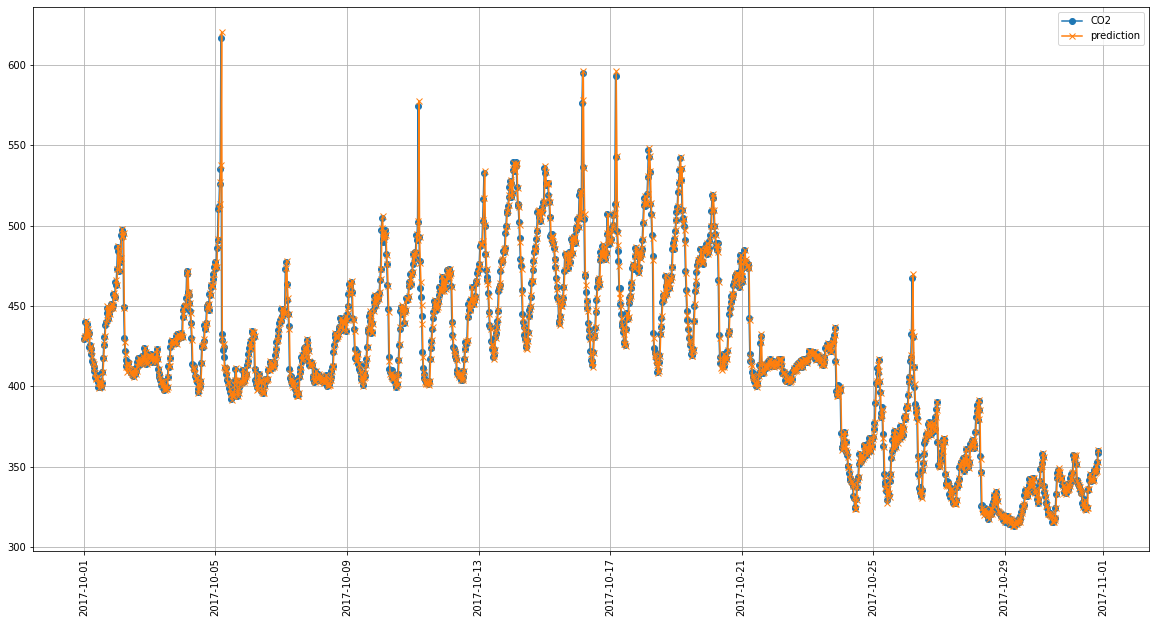

In [379]:
plt.figure(figsize=(20,10))
plt.plot(df_co2_zsbn.index.values[:-6],y, marker='o',label = "CO2")
plt.plot(df_co2_zsbn.index.values[:-6],y_pred, marker='x',label = "prediction" )
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

As we can see only using the CO2 data is not sufficient by itself. Drift is still there.

d) **3/35** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, use __current__ values of temperature and humidity as features,  as well as their __past__ values over the same interval of three hours, mathematically, $C_t \sim h(T_{t}, \cdots, T_{t-6}, H_{t}, \cdots, H_{t - 6})$, where $T_i$ and $H_i$ are temperature and humidity at time $i$. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why?

In [257]:
df_zsbn.columns

Index(['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity',
       'zone', 'altitude', 'lon', 'lat'],
      dtype='object')

In [259]:
df_zsbn = df_final[df_final['LocationName'] == "ZSBN"]
X_temp = np.zeros(X.shape)
for i in range(X_temp.shape[0]):
        X_temp[i, :] = np.asarray([df_zsbn["temperature"][i:i+6]])

In [260]:
X_hum= np.zeros(X.shape)
for i in range(X_hum.shape[0]):
        X_hum[i, :] = np.asarray([df_zsbn["humidity"][i:i+6]])

In [261]:
X_temp_hum = np.concatenate([X_temp, X_hum], axis=1)

In [380]:
tscv = TimeSeriesSplit()#default is 5 folds
currenterror = 1000000
X_cur = X_temp_hum
for train_index, test_index in tscv.split(X_cur):
    X_train,X_test,y_train,y_test = X_cur[train_index],X_cur[test_index],y[train_index],y[test_index]
    lr = LinearRegression(fit_intercept=False)
    lr = lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    scores = cross_val_score(lr, X_train, y_train, cv=tscv)
    print(scores)
    error = mean_squared_error(y_test, y_test_pred)
    print("MSE: "+ str(error))
    print("Average acc: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
    if currenterror > error:
        print(currenterror)
        currenterror = error
        lr_final = lr

[ -0.06241041 -19.97888332  -2.71618129   0.08333701 -33.28730755]
MSE: 1224.5548235768579
Average acc: -11.192 (+/- 13.329)
1000000
[-2.69608406 -0.79842666 -3.79822817 -0.32061752 -0.09817735]
MSE: 929.5954195520619
Average acc: -1.542 (+/- 1.453)
1224.5548235768579
[-0.96879514 -4.09432671  0.09694611  0.52293772 -0.10094896]
MSE: 1286.1606169840093
Average acc: -0.909 (+/- 1.665)
[-1.71015837  0.16103816  0.47100321 -0.19403738  0.05517663]
MSE: 3845.8576386350296
Average acc: -0.243 (+/- 0.764)
[-4.71110067  0.18726989 -0.20971766  0.19706785 -3.50262996]
MSE: 4984.994052707999
Average acc: -1.608 (+/- 2.081)


In [381]:
y_pred = lr_final.predict(X_temp_hum)

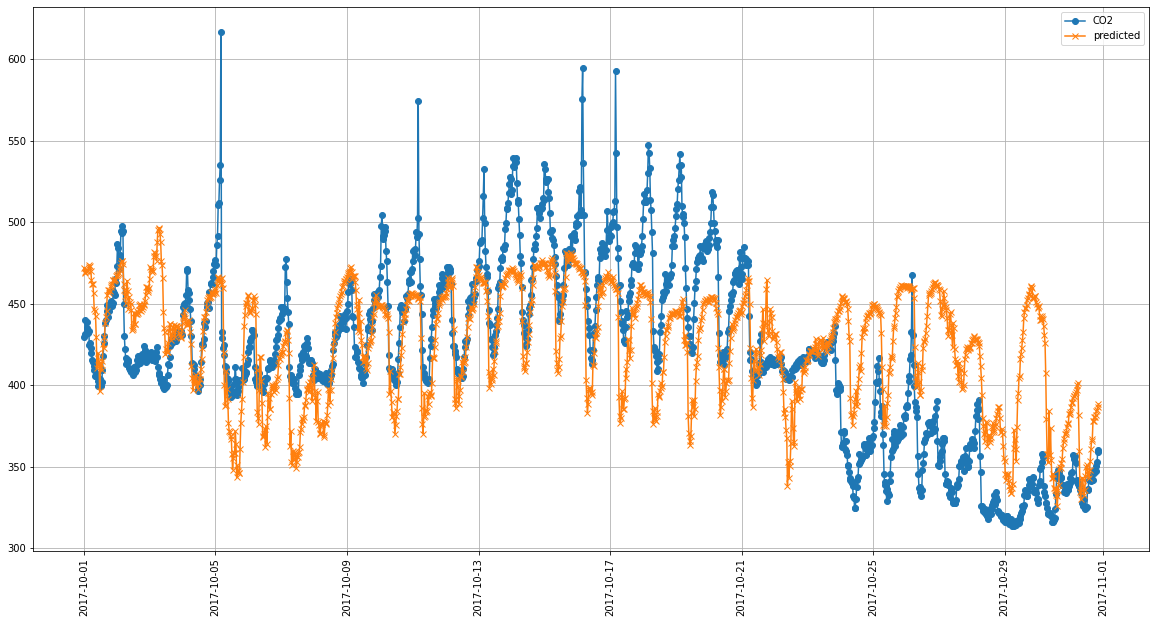

In [382]:
plt.figure(figsize=(20,10))
plt.plot(df_co2_zsbn.index.values[:-6],y, marker='o', label='CO2')
plt.plot(df_co2_zsbn.index.values[:-6],y_pred, marker='x', label='predicted')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

Now drift is removed, because now we are not looking for past CO2 values. However, this time problem is our predictions are not very accurate, which means we did not fit well. 

e) **6/35** Build another linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Discuss your findings.

Learn a model on other sensors: $ C_t^{S} \sim h(T_{t}^{S}, \cdots, T_{t - 6}^{S}, H_{t}^{S}, \cdots, H_{t - 6}^{S})$, where $S$ is the cluster of sensors experiencing similar conditions like ZSBN.

Apply the model on ZSBN to see if the drift has been removed: $\hat{C}_t^{ZSBN} = h(T_{t}^{ZSBN}, \cdots, T_{t - 6}^{ZSBN}, H_{t}^{ZSBN}, \cdots, H_{t - 6}^{ZSBN})$


In [276]:
df_final.columns

Index(['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity',
       'zone', 'altitude', 'lon', 'lat'],
      dtype='object')

We can collect values from columns **zone,altitude,lon,lat** where values are similiar to the ZSBN

In [283]:
zone = df_final[df_final['LocationName']=='ZSBN']['zone'][0]
altitude = df_final[df_final['LocationName']=='ZSBN']['altitude'][0]
lon = df_final[df_final['LocationName']=='ZSBN']['lon'][0]
lat = df_final[df_final['LocationName']=='ZSBN']['lat'][0]

Similiar locations in terms of zone

In [296]:
similar_zones = df_final[df_final['zone']==zone]['LocationName'].unique()
print(similar_zones)

['ZHRG' 'ZUE' 'ZSBN' 'ZRDH' 'ZHRZ' 'ZUBG']


In [305]:
#TODO : use part 2's clusters 
#For now I am only using zone information

In [487]:
similar_altitude = df_final[ (altitude-10< df_final['altitude']) & (df_final['altitude']  < altitude+10)]['LocationName'].unique()
print(similar_altitude)
num_data_points = df_final[df_final['LocationName']=='ZSBN'].shape[0]
similar_sensor_loc_names = []
for ln in similar_altitude:
    # Check if the number of datapoints is enough
    if df_final[df_final['LocationName']==ln].shape[0] == num_data_points:
        if ln != 'ZSBN': 
            similar_sensor_loc_names.append(ln)
print(similar_sensor_loc_names)

['ZGHD' 'ZHRG' 'ZSCH' 'ZUE' 'ZSBN' 'ZBLG' 'ZECB' 'ZSTA' 'ZLMT' 'ZPRD'
 'WSUM' 'ZALL' 'ZSEF' 'ZLDW']
['ZGHD', 'ZHRG', 'ZSCH', 'ZUE', 'ZBLG', 'ZECB', 'ZSTA', 'ZLMT', 'ZPRD', 'WSUM', 'ZALL', 'ZSEF', 'ZLDW']


In [488]:
similars = df_final[(df_final['zone']==zone)&(df_final['LocationName']!="ZSBN")]

In [489]:
datasize = len(df_co2_zsbn)- 6
y = np.zeros((datasize, 1))
for i in range(datasize):
        y[i] = df_co2_zsbn["CO2"][i+6]

In [520]:
# Then also collect temp and humidity from similiars
def similiar_Xs(co2=False):
    counter = 0
    X_agg = None
    y_agg = None
    for locname in similar_sensor_loc_names:
        if locname != "ZSBN":
            df_similiar_loc =  df_final[df_final['LocationName']==locname]
            df_similiar_loc = df_similiar_loc[['CO2', 'temperature', 'humidity']]
            if co2:
                X_co2 = np.zeros(X.shape)# X temperature
                for i in range(X_co2.shape[0]):
                    X_co2[i, :] = np.asarray([df_similiar_loc["CO2"][i:i+6]])
            X_temp = np.zeros(X.shape)# X temperature
            X_hum = np.zeros(X.shape) # X humidity
            yloc = np.zeros((X.shape[0], 1))
            for i in range(X_temp.shape[0]):
                X_temp[i, :] = np.asarray([df_similiar_loc["temperature"][i:i+6]])
                X_hum[i, :] = np.asarray([df_similiar_loc["humidity"][i:i+6]])
                yloc[i] = df_similiar_loc["CO2"][i+6]
            if counter == 0:
                if co2:
                    X_agg  = np.concatenate([X_co2,X_temp, X_hum], axis=1)
                else:
                    X_agg  = np.concatenate([X_temp, X_hum], axis=1)
                y_agg = y
                counter +=1
            
            if co2:
                 X_n = np.concatenate([X_co2,X_temp, X_hum], axis=1)
            else:
                X_n = np.concatenate([X_temp, X_hum], axis=1)
                
            X_agg = np.concatenate([X_agg, X_n], axis=0)
            y_agg = np.concatenate([y_agg, yloc])
            
    return X_agg,y_agg
X_agg,y_agg = similiar_Xs(co2=False)

In [521]:
print(X_agg.shape)
print(X_temp_hum.shape)
print(y_agg.shape)
print(y.shape)

(20748, 12)
(1482, 12)
(20748, 1)
(1482, 1)


In [509]:
tscv = TimeSeriesSplit()#default is 5 folds
currenterror = 1000000
X_cur = X_agg
for train_index, test_index in tscv.split(X_cur):
    print("Train: ",len(train_index))
    print("Test: ",len(test_index))
    X_train,X_test,y_train,y_test = X_cur[train_index],X_cur[test_index],y_agg[train_index],y_agg[test_index]
    lr = LinearRegression(fit_intercept=False)
    lr = lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    scores = cross_val_score(lr, X_train, y_train, cv=tscv)
    print(scores)
    error = mean_squared_error(y_test, y_test_pred)
    print("MSE: "+ str(error))
    print("Average acc: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
    if currenterror > error:
        print(currenterror)
        currenterror = error
        lr_final = lr

Train:  3458
Test:  3458
[  0.28457733   0.18283252 -11.64631233 -10.32905508  -1.89592096]
MSE: 4022.994131868151
Average acc: -4.681 (+/- 5.225)
1000000
Train:  6916
Test:  3458
[-0.49387273 -0.65126909 -1.5978966  -0.26269712 -0.41560912]
MSE: 3149.2521269621598
Average acc: -0.684 (+/- 0.474)
4022.994131868151
Train:  10374
Test:  3458
[-1.93187449 -1.46649477 -0.26826903 -0.55030752 -1.03357815]
MSE: 1810.409615768542
Average acc: -1.050 (+/- 0.602)
3149.2521269621598
Train:  13832
Test:  3458
[-0.27369933 -0.44181267 -1.05940587 -0.177401   -0.38720023]
MSE: 5112.929581409748
Average acc: -0.468 (+/- 0.310)
Train:  17290
Test:  3458
[-1.88140097 -0.60146511 -0.59570913 -0.13031421 -0.35412246]
MSE: 1804.8747177859473
Average acc: -0.713 (+/- 0.610)
1810.409615768542


In [507]:
y_pred = lr_final.predict(X_temp_hum)

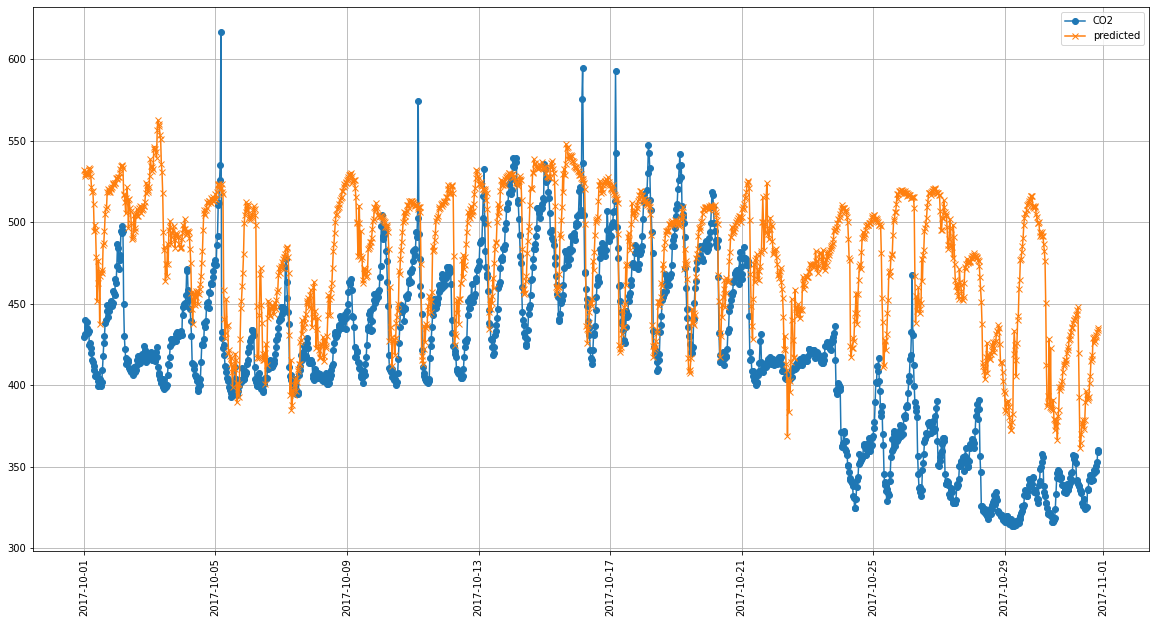

In [508]:
plt.figure(figsize=(20,10))
plt.plot(df_co2_zsbn.index.values[:-6],y, marker='o', label='CO2')
plt.plot(df_co2_zsbn.index.values[:-6],y_pred, marker='x', label='predicted')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

f) **5/35** Redo the question e) with [statsmodels](https://www.statsmodels.org/stable/index.html), a moudle for statistical models with an extensive list of result statistics. Build the linear regression model with statsmodels and examine the result statistics; keep features whose p-value are strictly less than 0.05 and build a new model. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the new model for the entire month of October. Discuss your findings.

__Note__: This introduciton page of [Linear Regression](https://www.statsmodels.org/stable/regression.html) may be helpful to you.

g) **10/35** In this question, we will use __Bayesian Structural Time Serie Modelling__ to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.


Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?

In [472]:
from causalimpact import CausalImpact


In [495]:
similar_sensor_loc_names

['ZGHD',
 'ZHRG',
 'ZSCH',
 'ZUE',
 'ZBLG',
 'ZECB',
 'ZSTA',
 'ZLMT',
 'ZPRD',
 'WSUM',
 'ZALL',
 'ZSEF',
 'ZLDW']

In [588]:
def create_X_attr(attr):
    final_arr = []
    for loc_name in similar_sensor_loc_names:
        if loc_name != 'ZSBN':
            arr = df[df['LocationName']==loc_name][attr].values
            final_arr = final_arr + [arr,]
    return np.asarray(t)
            

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 362.65. By contrast, in the absence of an
intervention, we would have expected an average response of 463.02.
The 95% interval of this counterfactual prediction is [450.15, 476.03].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -100.36 with a 95% interval of
[-113.38, -87.5]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 173709.78.
By contrast, had the intervention not taken place, we would have expected
a sum of 221784.49. The 95% interval of this prediction is [215621.49, 228019.75].


The above results are given in terms of absolute numbers. In relative
terms,

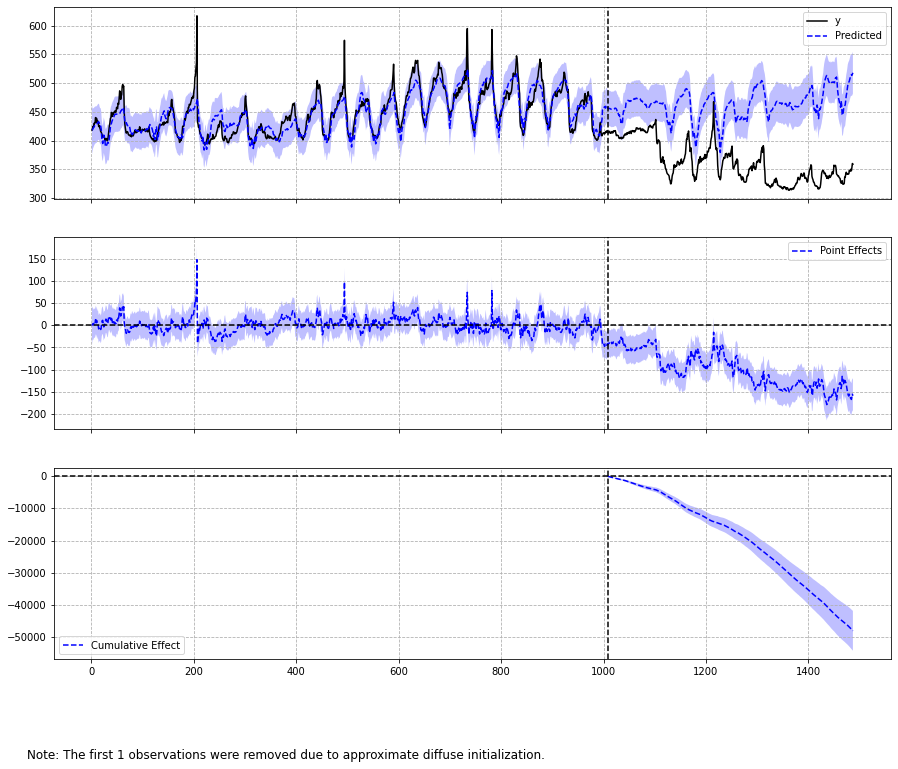

In [596]:
allX = []
x = []
for attr in ["CO2","temperature","humidity"]:
    allX += [create_X_attr(attr).T]
alX_concat = np.concatenate([allX[0],allX[1],allX[2]], axis=1)
y = df_final[df_final['LocationName']=='ZSBN']['CO2'].values
allinone = np.concatenate((np.expand_dims(y, axis=1), alX_concat), axis=1)
before= [0, 1008]
after = [1009, 1487]

ci = CausalImpact(allinone, before, after)
print(ci.summary("report"))
ci.plot()



In [ ]:
from sklearn import neural_network

h) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 

In [ ]:
tscv = TimeSeriesSplit()#default is 5 folds
currenterror = 1000000
for train_index, test_index in tscv.split(X_cur):
    X_train,X_test,y_train,y_test = X_agg[train_index],X_agg[test_index],y_agg[train_index],y_agg[test_index]
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)
    clf = neural_network.MLPRegressor(hidden_layer_sizes=(200, ), activation='relu', solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)
    clf = clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    scores = cross_val_score(clf, X_train, y_train, cv=tscv)
    print(scores)
    error = mean_squared_error(y_test, y_test_pred)
    print("MSE: "+ str(error))
    print("Average acc: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))
    if currenterror > error:
        print(currenterror)
        currenterror = error
        clf_final = clf
        
        


In [ ]:
y_pred = clf_final.predict(X_temp_hum)
plt.figure(figsize=(20,10))
plt.plot(df_co2_zsbn.index.values[:-6],y, marker='o', label='CO2')
plt.plot(df_co2_zsbn.index.values[:-6],y_pred, marker='x', label='predicted')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)